#Project :sep23_cds_int_medical_data
 This project is based on
 You'll find the : https://colab.research.google.com/drive/19XfV7YrCN9flbqOTBbq9hFapAlP2Q76L#scrollTo=psojH1HDy_Dr

The repo is still : https://drive.google.com/drive/folders/1ARQAwFnRb3wYpvhv5uRcUo-7qWnY_Gbc


# 1 Conect to DRIVE

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 Define the function to plot the images

In [ ]:
#Plot grayscale Image function
def PlotXRay (Image):
  plt.figure(figsize = (8,5))
  if len(Image.shape) == 2 :
    plt.imshow(Image, cmap = 'gray')
  else:
    plt.imshow(Image, cmap = 'RGB')
  plt.xticks([])
  plt.yticks([])

  plt.show();

# 3 Load the dataframe with the reference to all images

In [2]:
#load all Excel files into one df
import pandas as pd
df_COVID = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/COVID.metadata.xlsx')
df_Lung_Opacity = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Lung_Opacity.metadata.xlsx')
df_Normal = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Normal.metadata.xlsx')
df_Pneumonia = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Viral Pneumonia.metadata.xlsx')

df_COVID= df_COVID.drop(['FORMAT','SIZE','URL'],axis=1)
df_Lung_Opacity= df_Lung_Opacity.drop(['FORMAT','SIZE','URL'],axis=1)
df_Normal= df_Normal.drop(['FORMAT','SIZE','URL'],axis=1)
df_Pneumonia= df_Pneumonia.drop(['FORMAT','SIZE','URL'],axis=1)

df_COVID['Tag']="COVID"
df_Lung_Opacity['Tag']="Lung_Opacity"
df_Normal['Tag']="Normal"
df_Pneumonia['Tag']="Viral Pneumonia"

#Correct the Normal FILE NAME
df_Normal['FILE NAME']=df_Normal[df_Normal['Tag'].str.contains("Normal")]['FILE NAME'].str.replace('NORMAL','Normal')

XRay=pd.concat([df_COVID,df_Lung_Opacity,df_Normal,df_Pneumonia]) #add all [df_COVID,df_Lung_Opacity,df_Normal,df_Pneumonia]
print(XRay.shape)
XRay.head()

(21165, 2)


,FILE NAME,Tag
0,COVID-1,COVID
1,COVID-2,COVID
2,COVID-3,COVID
3,COVID-4,COVID
4,COVID-5,COVID


In [ ]:
#clean memory
del df_COVID
del df_Lung_Opacity
del df_Normal
del df_Pneumonia

#4 Load the Libraries

In [3]:

import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau




# 5 Especify the root path

In [4]:
#calculate the base path
BasePath = '/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/'


# Test (No need to execute)

In [ ]:

#load one image to TEST
index = 87

ImgPathFile = BasePath + XRay.iloc[index]['Tag']+'/images/'+XRay.iloc[index]['FILE NAME']+'.png'
imgX = mpimg.imread(ImgPathFile)
MaskPathFile = BasePath + XRay.iloc[index]['Tag']+'/masks/'+XRay.iloc[index]['FILE NAME']+'.png'
maskX = mpimg.imread(MaskPathFile)
GrayMaskX = maskX[:,:,0]

#check image and mask size and formats
print(imgX.shape)
print(imgX.dtype)
print( "imgX is between ", imgX.min() ," and ", imgX.max())

print(maskX.shape)
print(maskX.dtype)
print( "maskX is between ", maskX.min() ," and ", maskX.max())

print(GrayMaskX.shape)
print(GrayMaskX.dtype)
print( "GrayMaskX is between ", GrayMaskX.min() ," and ", GrayMaskX.max())

(299, 299)
float32
imgX is between  0.0  and  1.0
(256, 256, 3)
float32
maskX is between  0.0  and  1.0
(256, 256)
float32
GrayMaskX is between  0.0  and  1.0


In [ ]:
#Calculate cutImage TEST
GrayMaskX_resized = cv2.resize(GrayMaskX, (imgX.shape[1], imgX.shape[0]))


cutImage = imgX * GrayMaskX_resized


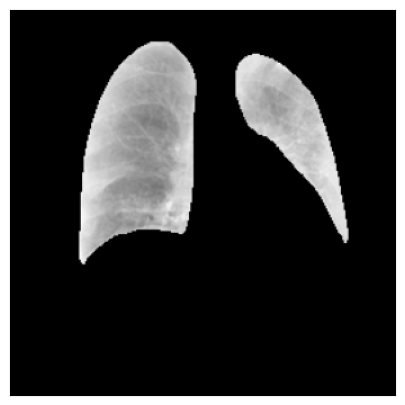

In [ ]:
# plot cuted image TEST
PlotXRay(cutImage*255)


# 6 Run **only ones** to preprocessing the images

In [ ]:
# PRE process the images and apply the mask
for index, row in XRay.iterrows():  #76 imag/min
  ImgPathFile = BasePath + XRay.iloc[index]['Tag']+'/images/'+XRay.iloc[index]['FILE NAME']+'.png'
  print(ImgPathFile)
  imgXorig = mpimg.imread(ImgPathFile)
  imgX = cv2.resize(imgXorig,(224,224),interpolation = cv2.INTER_NEAREST)
  MaskPathFile = BasePath + XRay.iloc[index]['Tag']+'/masks/'+XRay.iloc[index]['FILE NAME']+'.png'
  maskXorig = mpimg.imread(MaskPathFile)
  maskX = cv2.resize(maskXorig,(224,224),interpolation = cv2.INTER_NEAREST)
  if len(imgX.shape) == 2 and len(maskX.shape) == 2:
    cutImage = imgX*maskX
    cutImage = cv2.cvtColor(cutImage,cv2.COLOR_GRAY2RGB) #convert to RGB
  elif len(imgX.shape) == 2 and len(maskX.shape) == 3:
    GrayMaskX = maskX[:,:,0]
    cutImage = imgX*GrayMaskX
    cutImage = cv2.cvtColor(cutImage,cv2.COLOR_GRAY2RGB) #convert to RGB
  elif len(imgX.shape) == 3 and len(maskX.shape) == 2:
    GrayMaskX = np.repeat(maskX[..., np.newaxis], 3, -1) #convert to RGB
    cutImage = imgX*GrayMaskX
  else:
    cutImage = imgX*maskX
  FileName = BasePath + 'CutImages/'+XRay.iloc[index]['FILE NAME']+'.jpg'
  cv2.imwrite(FileName, cutImage*255)

In [ ]:
XRay.groupby('Tag').count()

,FILE NAME
Tag,
COVID,3616
Lung_Opacity,6012
Normal,10192
Viral Pneumonia,1345


#7 select **balaced** or **all** sub set of images to use in the train and test

In [5]:

#select Data to train
XRay['Image Path'] = BasePath + 'CutImages/'+ XRay['FILE NAME']+'.jpg'

#mapping = {'Normal':0,'Lung_Opacity':1,'Viral Pneumonia':2,'COVID':3}
#XRay=XRay.replace({'Tag': mapping})

print('Select ("a" = All images, "b" = subset balanced; "c" = use augmented dataset to simulate 6000 Images on each category):')
x = input()
if x == 'b' :
  NumberViralPneumonia=1345
  NumberNormal=1400
  NumberLungOpacity=1400
  NumberCovid=1400
else:
  NumberViralPneumonia=1345
  NumberNormal=10192
  NumberLungOpacity=6012
  NumberCovid=3612

PenumoniaDF = XRay.loc[XRay['Tag']=='Viral Pneumonia']
NormalDF = XRay.loc[XRay['Tag']=='Normal'].sample(NumberNormal)
Lung_OpacityDF = XRay.loc[XRay['Tag']=='Lung_Opacity'].sample(NumberLungOpacity)
CovidDF = XRay.loc[XRay['Tag']=='COVID'].sample(NumberCovid)

test_size = 0.10
Validate_size = 0.30
train_size = 1 - test_size - Validate_size

TrainDFPenumonia = PenumoniaDF.iloc[:int(train_size * len(PenumoniaDF))]
TrainDFNormal = NormalDF.iloc[:int(train_size * len(NormalDF))]
TrainDFLung_Opacity = Lung_OpacityDF.iloc[:int(train_size * len(Lung_OpacityDF))]
TrainDFCovid = CovidDF.iloc[:int(train_size * len(CovidDF))]

ValidateDFPenumonia = PenumoniaDF.iloc[int(train_size * len(PenumoniaDF)):int((train_size + Validate_size) * len(PenumoniaDF))]
ValidateDFNormal = NormalDF.iloc[int(train_size * len(NormalDF)):int((train_size + Validate_size) * len(NormalDF))]
ValidateDFLung_Opacity = Lung_OpacityDF.iloc[int(train_size * len(Lung_OpacityDF)):int((train_size + Validate_size) * len(Lung_OpacityDF))]
ValidateDFCovid = CovidDF.iloc[int(train_size * len(CovidDF)):int((train_size + Validate_size) * len(CovidDF))]

TestDFPenumonia = PenumoniaDF.iloc[int((train_size + Validate_size) * len(PenumoniaDF)):]
TestDFNormal = NormalDF.iloc[int((train_size + Validate_size) * len(NormalDF)):]
TestDFLung_Opacity = Lung_OpacityDF.iloc[int((train_size + Validate_size) * len(Lung_OpacityDF)):]
TestDFCovid = CovidDF.iloc[int((train_size + Validate_size) * len(CovidDF)):]

'''optionc uses 6000 images for each category'''
if x == 'c' :
  TrainDFPenumoniaMult = pd.concat([TrainDFPenumonia,TrainDFPenumonia], ignore_index=True)
  TrainDFPenumoniaMult = pd.concat([TrainDFPenumoniaMult,TrainDFPenumonia], ignore_index=True)
  TrainDFPenumoniaMult = pd.concat([TrainDFPenumoniaMult,TrainDFPenumonia], ignore_index=True)
  TrainDFPenumoniaMult = pd.concat([TrainDFPenumoniaMult,TrainDFPenumonia], ignore_index=True)
  TrainDFPenumonia = TrainDFPenumoniaMult.iloc[:int(train_size * 6000)]
  TrainDFNormal = TrainDFNormal.iloc[:int(train_size * 6000)]
  TrainDFLung_Opacity = TrainDFLung_Opacity.iloc[:int(train_size * 6000)]
  TrainDFCovidMult= pd.concat([TrainDFCovid,TrainDFCovid], ignore_index=True)
  TrainDFCovid = TrainDFCovidMult.iloc[:int(train_size * 6000)]

  ValidateDFPenumoniaMult = pd.concat([ValidateDFPenumonia,ValidateDFPenumonia], ignore_index=True)
  ValidateDFPenumoniaMult = pd.concat([ValidateDFPenumoniaMult,ValidateDFPenumonia], ignore_index=True)
  ValidateDFPenumoniaMult = pd.concat([ValidateDFPenumoniaMult,ValidateDFPenumonia], ignore_index=True)
  ValidateDFPenumoniaMult = pd.concat([ValidateDFPenumoniaMult,ValidateDFPenumonia], ignore_index=True)
  ValidateDFPenumonia = ValidateDFPenumoniaMult.iloc[:int(Validate_size * 6000)]
  ValidateDFNormal = ValidateDFNormal.iloc[:int(Validate_size * 6000)]
  ValidateDFLung_Opacity = ValidateDFLung_Opacity.iloc[:int(Validate_size * 6000)]
  ValidateDFCovidMult= pd.concat([ValidateDFCovid,ValidateDFCovid], ignore_index=True)
  ValidateDFCovid = ValidateDFCovidMult.iloc[:int(Validate_size * 6000)]

  TestDFPenumoniaMult = pd.concat([TestDFPenumonia,TestDFPenumonia], ignore_index=True)
  TestDFPenumoniaMult = pd.concat([TestDFPenumoniaMult,TestDFPenumonia], ignore_index=True)
  TestDFPenumoniaMult = pd.concat([TestDFPenumoniaMult,TestDFPenumonia], ignore_index=True)
  TestDFPenumoniaMult = pd.concat([TestDFPenumoniaMult,TestDFPenumonia], ignore_index=True)
  TestDFPenumonia = TestDFPenumoniaMult.iloc[:int(test_size * 6000)]
  TestDFNormal = TestDFNormal.iloc[:int(test_size * 6000)]
  TestDFLung_Opacity = TestDFLung_Opacity.iloc[:int(test_size * 6000)]
  TestDFCovidMult= pd.concat([TestDFCovid,TestDFCovid], ignore_index=True)
  TestDFCovid = TestDFCovidMult.iloc[:int(test_size * 6000)]

TrainDF = pd.concat([TrainDFPenumonia,TrainDFNormal], ignore_index=True)
TrainDF = pd.concat([TrainDF,TrainDFLung_Opacity], ignore_index=True)
TrainDF = pd.concat([TrainDF,TrainDFCovid], ignore_index=True)

ValidateDF = pd.concat([ValidateDFPenumonia,ValidateDFNormal], ignore_index=True)
ValidateDF = pd.concat([ValidateDF,ValidateDFLung_Opacity], ignore_index=True)
ValidateDF = pd.concat([ValidateDF,ValidateDFCovid], ignore_index=True)

TestDF = pd.concat([TestDFPenumonia,TestDFNormal], ignore_index=True)
TestDF = pd.concat([TestDF,TestDFLung_Opacity], ignore_index=True)
TestDF = pd.concat([TestDF,TestDFCovid], ignore_index=True)

TrainDF['FILE NAME'] = TrainDF['FILE NAME']+'.jpg'
ValidateDF['FILE NAME'] = ValidateDF['FILE NAME']+'.jpg'
TestDF['FILE NAME'] = TestDF['FILE NAME']+'.jpg'

# Assigning labels for train and test sets
TrainDF['IsTrain'] = 1
TestDF['IsTrain'] = 0
print (TestDF.shape)

Select ("a" = All images, "b" = subset balanced; "c" = use augmented dataset to simulate 6000 Images on each category):
c
(2400, 4)


In [ ]:
TrainDF.groupby('Tag').count()

,FILE NAME,Image Path,IsTrain
Tag,,,
COVID,840,840,840
Lung_Opacity,840,840,840
Normal,840,840,840
Viral Pneumonia,807,807,807


In [ ]:
ValidateDF.groupby('Tag').count()

,FILE NAME,Image Path
Tag,,
COVID,420,420
Lung_Opacity,420,420
Normal,420,420
Viral Pneumonia,403,403


In [ ]:
TestDF.groupby('Tag').count()

,FILE NAME,Image Path,IsTrain
Tag,,,
COVID,140,140,140
Lung_Opacity,140,140,140
Normal,140,140,140
Viral Pneumonia,135,135,135


#save the datasets to be able to retrain latter with the same data .


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/TrainDF6000.csv','w', encoding = 'utf-8-sig') as TrainFile:
  TrainDF.to_csv(TrainFile)

with open('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ValidateDF6000.csv','w', encoding = 'utf-8-sig') as ValidateFile:
  ValidateDF.to_csv(ValidateFile)

with open('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/TestDF6000.csv','w', encoding = 'utf-8-sig') as TestFile:
  TestDF.to_csv(TestFile)




# 8 Keras

##Image files loader (images path defined in the dataframe)

example:

https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_dataframe/



In [6]:
# create data generator
if x == 'c' :
  train_datagen = ImageDataGenerator(rescale = 1 / 255.0,
                                     rotation_range=15,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True,
                                     fill_mode='nearest')
else:
  train_datagen = ImageDataGenerator(rescale = 1 / 255.0)

validation_datagen = ImageDataGenerator(rescale = 1 / 255.0)
test_datagen = ImageDataGenerator(rescale = 1 / 255.0)

batch_size=64




In [7]:
# create iterator
# Convert 'Tag' column to strings
TrainDF.loc[:, 'Tag'] = TrainDF['Tag'].astype(str)
TestDF.loc[:, 'Tag'] = TestDF['Tag'].astype(str)
#the dataframe must have Filename.ext, Targer as STR
train_generator = train_datagen.flow_from_dataframe(
    dataframe=TrainDF,
    directory=BasePath + 'CutImages/',
    x_col='FILE NAME',
    y_col="Tag",
    batch_size=batch_size,
    class_mode='sparse',                      # Change class_mode to "sparse"
    target_size=(224, 224),  # Update target_size to match model input shape
    subset='training',  # Specify training subset for validation split
    shuffle=True,
    seed=42
)

# Create iterator for validation data with sparse labels
valid_generator = validation_datagen.flow_from_dataframe(
    dataframe=ValidateDF,
    directory=BasePath + 'CutImages/',
    x_col='FILE NAME',
    y_col="Tag",
    batch_size=batch_size,
    class_mode='sparse',
    target_size=(224, 224),

)

# create iterator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=TestDF,
    directory=BasePath + 'CutImages/',
    x_col='FILE NAME',
    y_col="Tag",
    batch_size=1,
    target_size=(224, 224),
    class_mode='sparse',         # No class mode for test data
    shuffle=False
)

Found 14400 validated image filenames belonging to 4 classes.
Found 7200 validated image filenames belonging to 4 classes.
Found 2400 validated image filenames belonging to 4 classes.


##Define the VGG16 Keras model

In [8]:
import keras
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU,UpSampling2D,concatenate
from keras.models import Model, Sequential, load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Model
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="64cov_l1", input_shape=[224,224,3]))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="64cov_l2"))
model.add(MaxPooling2D((2, 2), strides=(2, 2),name ="max_pooll_l3"))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="128cov_l4"))
#model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding='same', name ="128cov_l5"))
model.add(MaxPooling2D((2, 2), strides=(2, 2),name ="max_pooll_l6"))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l7"))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l8"))
#model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l9"))
#model.add(Conv2D(filters = 256, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l10"))
model.add(MaxPooling2D((2, 2), strides=(2, 2),name ="max_pooll_l11"))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l12"))
model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l13"))
#model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l14"))
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l15"))
model.add(MaxPooling2D((2, 2), strides=(2, 2),name ="max_pooll_l16"))

# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l17"))
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l18"))
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l19"))
# model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding='same', name ="256cov_l20"))
# model.add(MaxPooling2D((2, 2), strides=(2, 2),name ="max_pooll_l21"))

model.add(Flatten(name ="flat_layer"))

model.add(Dense(units = 64, activation = 'relu',name ="dense_l23"))
model.add(Dense(units = 128, activation = 'relu',name ="dense_l24"))
# model.add(Dense(units = 1024, activation = 'relu',name ="dense_l25"))
model.add(Dense(units = 4, activation = 'softmax',name ="output_dense_26"))


# Loss Function
model.compile(loss='sparse_categorical_crossentropy', # fonction de perte
              optimizer='adam',                # algorithme d'optimisation
              metrics=['accuracy'])            # métrique d'évaluation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 64cov_l1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 64cov_l2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooll_l3 (MaxPooling2D  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 128cov_l4 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooll_l6 (MaxPooling2D  (None, 56, 56, 64)        0         
 )                                                               
                                                                 
 256cov_l7 (Conv2D)          (None, 56, 56, 64)        3

##Train the model

In [ ]:
# Define callbacks
early_stop = EarlyStopping(monitor='loss', patience=4, verbose=1, mode = 'min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=2,mode = 'min', min_lr=0.00001)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)

# train
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    epochs=10,
    callbacks=[ model_checkpoint,early_stop,reduce_lr]
)


Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.5371 
Epoch 1: loss improved from inf to 1.00348, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5
52/52 [==============================] - 1881s 36s/step - loss: 1.0035 - accuracy: 0.5371 - val_loss: 0.7881 - val_accuracy: 0.6512 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.6739
Epoch 2: loss improved from 1.00348 to 0.73400, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5
52/52 [==============================] - 26s 495ms/step - loss: 0.7340 - accuracy: 0.6739 - val_loss: 0.7450 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 3/10
52/52 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7157
Epoch 3: loss improved from 0.73400 to 0.65562, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5
52/52 [==============================] - 26s 499ms/step - loss: 0.6556 - accuracy: 0.7157 - val_loss: 0.6561 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.7526
Epoch 4: loss improved from 0.65562 to 0.59311, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5
52/52 [============================

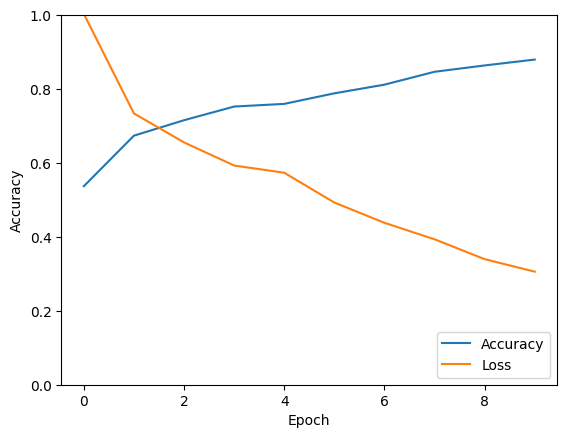

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()




In [ ]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

#epoc 12+

555/555 [==============================] - 210s 377ms/step - loss: 0.7213 - accuracy: 0.7315


In [ ]:
predY=model.predict(test_generator, steps=len(test_generator))

In [ ]:
predY=model.predict(test_generator, steps=len(test_generator))
predY=np.round(predY).astype(int).reshape(1,-1)[0]

from sklearn.metrics import confusion_matrix
m=confusion_matrix(predY,test_generator)
tn, fn, fp, tp=confusion_matrix(predY,test_generator).ravel()
m=pd.crosstab(predY,test_generator)
print("Confusion matrix")
print(m)

# load a saved model
 and then retrain execute the DF loader and the Iterators defenition

 to retrain we need to save the dataframes to use the same images as train and test

In [ ]:
import pandas as pd

TrainDF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/TrainDF6000.csv')
ValidateDF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ValidateDF6000.csv')
TestDF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/TestDF6000.csv')

print('what was the Selected when the data was criated ("a" = All images, "b" = subset balanced; "c" = use augmented dataset to simulate 6000 Images on each category):')
x = input()

what was the Selected when the data was criated ("a" = All images, "b" = subset balanced; "c" = use augmented dataset to simulate 6000 Images on each category):
c


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5')
# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 64cov_l1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 64cov_l2 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooll_l3 (MaxPooling2D  (None, 112, 112, 64)      0         
 )                                                               
                                                                 
 128cov_l4 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooll_l6 (MaxPooling2D  (None, 56, 56, 64)        0         
 )                                                               
                                                                 
 256cov_l7 (Conv2D)          (None, 56, 56, 64)        3

# data augmentation

In [ ]:
#Karin Model Example
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/best_model.h5'
if not os.path.exists(model_path):
    # Train the model
    # Data augmentation
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=15,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    # Define batch size
    batch_size = 32

In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=TrainDF, x_col= 'Image Path', y_col='Tag', target_size=(224, 224), batch_size=batch_size, class_mode='sparse')
validation_datagen = ImageDataGenerator(rescale = 1 / 255.0)
validation_generator = validation_datagen.flow_from_dataframe(dataframe=ValidateDF, x_col='Image Path', y_col='Tag',
                                                    target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# ResNet50 Model

In [9]:

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Additional layers
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid')(base_model.output)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Dropout(rate=0.2)(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=134, activation='relu')(x)
output = Dense(units=4, activation='softmax')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', # loss function
              optimizer='adam',                # optimization algorithm
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Define callbacks
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ResNet50.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [10]:
# Recreate the exact same model, including its weights and the optimizer

history = model.fit(
        train_generator,
        validation_data=valid_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(valid_generator),
        epochs=20,
        callbacks=[model_checkpoint]
    )

# Load the model
#new_model = load_model(model_path)

# Show the model architecture
#new_model.summary()

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 1.3746 - accuracy: 0.2887 
Epoch 1: loss improved from inf to 1.37460, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ResNet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 5894s 26s/step - loss: 1.3746 - accuracy: 0.2887 - val_loss: 1.3066 - val_accuracy: 0.3733
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 1.2884 - accuracy: 0.3875
Epoch 2: loss improved from 1.37460 to 1.28844, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ResNet50.h5
225/225 [==============================] - 275s 1s/step - loss: 1.2884 - accuracy: 0.3875 - val_loss: 1.1385 - val_accuracy: 0.4639
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 1.2103 - accuracy: 0.4235
Epoch 3: loss improved from 1.28844 to 1.21029, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/ResNet50.h5
225/225 [==============================] - 269s 1s/step - loss: 1.2103 - accuracy: 0.4235 - val_loss: 1.1044 - val_accuracy: 0.4711
Epoch 4/10
225/225 [==============================] - ETA: 0s - loss: 1.1770 - accuracy: 0.4383
Epoch 4: loss improved from 1.21029 to 1.17699, saving m

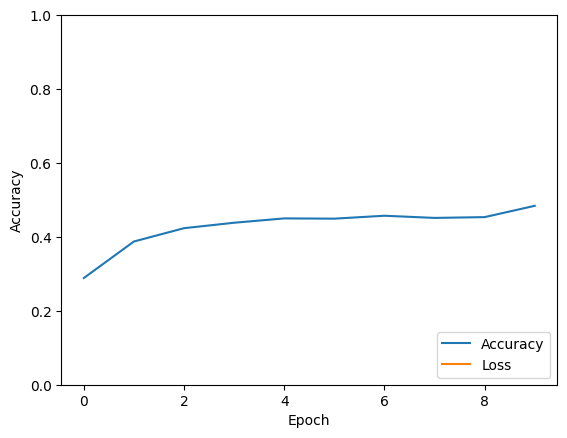

2400/2400 [==============================] - 648s 269ms/step - loss: 0.9650 - accuracy: 0.5571
Test Accuracy: 0.5570833086967468
Test Loss: 0.9650207757949829


In [11]:
# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def unet_model(input_size=(224, 224, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(pool3), conv3], axis=-1)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv2], axis=-1)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv1], axis=-1)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(16, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    return Model(inputs, conv6)

# Create UNet model
unet_base_model = unet_model()

# Additional layers on top of UNet model
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(unet_base_model.output)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dense(units=4, activation='softmax')(x)

# Create a new model
model = Model(inputs=unet_base_model.input, outputs=x)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Print model summary
model.summary()


# Define callbacks
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/unet_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 224, 224, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d_4[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 conv2d_5 (Conv2D)           (None, 224, 224, 16)         2320      ['batch_normalization[0]

In [ ]:
# Training U-Net
history_unet = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    callbacks=[ model_checkpoint]
)

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 1.3211 - accuracy: 0.3983
Epoch 1: loss improved from inf to 1.32107, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/unet_model.h5
225/225 [==============================] - 361s 1s/step - loss: 1.3211 - accuracy: 0.3983 - val_loss: 1.6700 - val_accuracy: 0.1953
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 1.1138 - accuracy: 0.4867
Epoch 2: loss improved from 1.32107 to 1.11377, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/unet_model.h5
225/225 [==============================] - 331s 1s/step - loss: 1.1138 - accuracy: 0.4867 - val_loss: 2.0061 - val_accuracy: 0.4149
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.5218
Epoch 3: loss improved from 1.11377 to 1.03919, saving model to /content/drive/MyDrive/Colab Notebooks/X_Ray_Project/unet_model.h5
225/225 [==============================] - 334s 1s/step - l

In [1]:
# Plot training history
plt.plot(history_unet.history['accuracy'], label='Accuracy')
plt.plot(history_unet.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

NameError: name 'plt' is not defined

Epoch 1/50
599/599 [==============================] - ETA: 0s - loss: 1.1660 - accuracy: 0.5012
Epoch 1: val_loss improved from inf to 1.15135, saving model to best_model.h5
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
599/599 [==============================] - 6247s 10s/step - loss: 1.1660 - accuracy: 0.5012 - val_loss: 1.1513 - val_accuracy: 0.6385 - lr: 0.0010
Epoch 2/50
599/599 [==============================] - ETA: 0s - loss: 1.1135 - accuracy: 0.5364
Epoch 2: val_loss did not improve from 1.15135

In [ ]:
# Mask R-CNN Model


# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Additional layers (# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Additional layers (Mask R-CNN)
x = base_model.output

# Add Mask R-CNN layers here...

# Example: add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Example: add a fully connected layer
x = Dense(256, activation='relu')(x)

# Example: add a classification layer for predicting classes
classification_output = Dense(num_classes, activation='softmax', name='classification_output')(x)

# Example: add a mask prediction layer
mask_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name='mask_output')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=[classification_output, mask_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'classification_output': 'categorical_crossentropy', 'mask_output': 'binary_crossentropy'},
              metrics={'classification_output': 'accuracy', 'mask_output': 'accuracy'})

# Summary of the model
model.summary()

x = base_model.output

# Add Mask R-CNN layers here...

# Example: add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Example: add a fully connected layer
x = Dense(256, activation='relu')(x)

# Example: add a classification layer for predicting classes
classification_output = Dense(num_classes, activation='softmax', name='classification_output')(x)

# Example: add a mask prediction layer
mask_output = Conv2D(num_classes, (1, 1), activation='sigmoid', name='mask_output')(x)

# Create a new model
model = Model(inputs=base_model.input, outputs=[classification_output, mask_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'classification_output': 'categorical_crossentropy', 'mask_output': 'binary_crossentropy'},
              metrics={'classification_output': 'accuracy', 'mask_output': 'accuracy'})

# Summary of the model
model.summary()


In [ ]:
#check image and mask size and formats
print(imgX.shape)
print(imgX.dtype)
print( "imgX is between ", imgX.min() ," and ", imgX.max())

print(maskX.shape)
print(maskX.dtype)
print( "imgX is between ", maskX.min() ," and ", maskX.max())

print(GrayMaskX.shape)
print(GrayMaskX.dtype)
print( "imgX is between ", GrayMaskX.min() ," and ", GrayMaskX.max())

In [ ]:
#resize the mask
GrayMaskX299299 = cv2.resize(GrayMaskX, (299, 299),
               interpolation = cv2.INTER_NEAREST)

print(GrayMaskX299299.shape)
print(GrayMaskX299299.dtype)
print( "imgX is between ", GrayMaskX299299.min() ," and ", GrayMaskX299299.max())

In [ ]:
#Plot images
PlotXRay(imgX)
PlotXRay(GrayMaskX299299)

In [ ]:
ZeroImg = np.zeros_like (imgX[:,:], dtype='uint8')
img255=ZeroImg+255

In [ ]:
#Calculate cutImage
cutImage = imgX*GrayMaskX299299
#cutImage = cv2.bitwise_and(imgX*255,GrayMaskX299299) # doesn't work as expected

In [ ]:
#plot cuted image
PlotXRay(cutImage)


In [ ]:
#please review


def preprocess_image(image_path, target_shape):

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape[:2])
    img = cv2.equalizeHist(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    #img = cv2.medianBlur(img, 5)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    lung_mask = segment_lungs(img)
    img = cv2.bitwise_and(img, lung_mask)
    return img



def segment_lungs(img):

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img)

    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

    return mask


def preprocess_mask(mask_path, target_shape):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_shape[:2])
    mask = mask / 255.0
    return mask



target_shape = (299, 299, 3)


for i in range(len(df_COVID)):
    image_path = df_COVID.iloc[i]['Image Path']
    mask_path = df_COVID.iloc[i]['Mask Path']
    img = preprocess_image(image_path, target_shape)
    mask = preprocess_mask(mask_path, target_shape)

    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Preprocessed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
Lung_Opacity_Images='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Lung_Opacity/images'
Lung_Opacity_Masks='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Lung_Opacity/masks'
df_Lung_Opacity['Image Path']=df_Lung_Opacity['FILE NAME'].apply(lambda x: f"{Lung_Opacity_Images}/{x}.png")
df_Lung_Opacity['Mask Path']=df_Lung_Opacity['FILE NAME'].apply(lambda x: f"{Lung_Opacity_Masks}/{x}.png")




print(df_Lung_Opacity.head())
print(df_Lung_Opacity.count())

image_path = df_Lung_Opacity.iloc[0]['Image Path']
img = cv2.imread(image_path)
print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()

image_path = df_Lung_Opacity.iloc[0]['Mask Path']
img = cv2.imread(image_path)

print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_image(image_path, target_shape):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape[:2])
    img = img / 255.0
    return img


def preprocess_mask(mask_path, target_shape):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_shape[:2])
    mask = mask / 255.0
    return mask



target_shape = (256, 256, 3)


for i in range(len(df_Lung_Opacity)):
    image_path = df_Lung_Opacity.iloc[i]['Image Path']
    mask_path = df_Lung_Opacity.iloc[i]['Mask Path']
    img = preprocess_image(image_path, target_shape)
    mask = preprocess_mask(mask_path, target_shape)

    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Preprocessed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
Normal_Images='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Normal/images'
Normal_Masks='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Normal/masks'
df_Normal['Image Path']=df_Normal['FILE NAME'].str.capitalize().apply(lambda x: f"{Normal_Images}/{x}.png")
df_Normal['Mask Path']=df_Normal['FILE NAME'].str.capitalize().apply(lambda x: f"{Normal_Masks}/{x}.png")


print(df_Normal.head())

print(df_Normal.count())
image_path = df_Normal.iloc[0]['Image Path']
img = cv2.imread(image_path)
print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()


image_path = df_Normal.iloc[0]['Mask Path']
img = cv2.imread(image_path)
print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_image(image_path, target_shape):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape[:2])
    img = img / 255.0
    return img


def preprocess_mask(mask_path, target_shape):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_shape[:2])
    mask = mask / 255.0
    return mask



target_shape = (256, 256, 3)


for i in range(len(df_Normal)):
    image_path = df_Normal.iloc[i]['Image Path']
    mask_path = df_Normal.iloc[i]['Mask Path']
    img = preprocess_image(image_path, target_shape)
    mask = preprocess_mask(mask_path, target_shape)

    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Preprocessed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
Pneumonia_Images='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Viral Pneumonia/images'
Pneumonia_Masks='/content/drive/MyDrive/Colab Notebooks/X_Ray_Project/Viral Pneumonia/masks'
df_Pneumonia['Image Path']=df_Pneumonia['FILE NAME'].apply(lambda x: f"{Pneumonia_Images}/{x}.png")
df_Pneumonia['Mask Path']=df_Pneumonia['FILE NAME'].apply(lambda x: f"{Pneumonia_Masks}/{x}.png")



print(df_Pneumonia.head())
print(df_Pneumonia.count())
image_path = df_Pneumonia.iloc[0]['Image Path']
img = cv2.imread(image_path)
print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()

image_path = df_Pneumonia.iloc[0]['Mask Path']
img = cv2.imread(image_path)
print(img.shape)
b, g, r = cv2.split(img)


plt.figure(figsize=(7, 5))

plt.subplot(1, 3, 1)
plt.imshow(b)
plt.title('X')

plt.subplot(1, 3, 2)
plt.imshow(g)
plt.title('Y')

plt.subplot(1, 3, 3)
plt.imshow(r)
plt.title('Z')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_image(image_path, target_shape):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape[:2])
    img = img / 255.0
    return img


def preprocess_mask(mask_path, target_shape):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_shape[:2])
    mask = mask / 255.0
    return mask



target_shape = (256, 256, 3)


for i in range(len(df_Pneumonia)):
    image_path = df_Pneumonia.iloc[i]['Image Path']
    mask_path = df_Pneumonia.iloc[i]['Mask Path']
    img = preprocess_image(image_path, target_shape)
    mask = preprocess_mask(mask_path, target_shape)

    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Preprocessed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Preprocessed Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()